In [1]:
import sys

sys.path.append("../")

In [2]:
import requests
import time
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands

import matplotlib.pyplot as plt


In [3]:
API_BASE = 'https://fapi.binance.com/fapi/v1/'
TIMEFRAME = '1h'
lookback = 60

# TIMEFRAME = '5m'
# lookback = 15

In [4]:


LABELS = [
    'open_time',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]

DROP_COLUMNS=[
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]


def get_batch(symbol, interval='1m', start_time=0, limit=1000):
    """Use a GET request to retrieve a batch of candlesticks. Process the JSON into a pandas
    dataframe and return it. If not successful, return an empty dataframe.
    """

    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }
    try:
        # timeout should also be given as a parameter to the function
        response = requests.get(f'{API_BASE}klines', params, timeout=30)
    except requests.exceptions.ConnectionError:
        print('Connection error, Cooling down for 5 mins...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    except requests.exceptions.Timeout:
        print('Timeout, Cooling down for 5 min...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    if response.status_code == 200:
        return pd.DataFrame(response.json(), columns=LABELS)
    
    print(f'Got erroneous response back {symbol}: {response}. {response.text}')
    return pd.DataFrame([])


def get_candles(base, quote, start_date: datetime, interval='1m'):
    batches = []

    last_timestamp = int(start_date.timestamp()) * 1000
    # gather all candlesticks available, starting from the last timestamp loaded from disk or 0
    # stop if the timestamp that comes back from the api is the same as the last one
    previous_timestamp = None

    while previous_timestamp != last_timestamp:
        # stop if we reached data from today
        if datetime.fromtimestamp(last_timestamp / 1000) >= datetime.utcnow():
            break

        previous_timestamp = last_timestamp

        new_batch = get_batch(
            symbol=base + quote,
            interval=interval,
            start_time=last_timestamp
        )

        # requesting candles from the future returns empty
        # also stop in case response code was not 200
        if new_batch.empty:
            break

        last_timestamp = new_batch['open_time'].max()

        # sometimes no new trades took place yet on date.today();
        # in this case the batch is nothing new
        if previous_timestamp == last_timestamp:
            break

        batches.append(new_batch)
        last_datetime = datetime.fromtimestamp(last_timestamp / 1000)

        covering_spaces = 20 * ' '
        print(datetime.now(), base, quote, interval, str(last_datetime) + covering_spaces, end='\r', flush=True)

    if len(batches) > 0:
        # write clean version of csv to parquet
        df = pd.concat(batches, ignore_index=True)
        df.drop(columns=DROP_COLUMNS, inplace=True)
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        return df



In [5]:
# symbols = pd.read_csv(f'{DATA_PATH}/../symbols.csv')['symbol'].values.tolist()
symbols = ['BTCUSDT',
 'ETHUSDT',
 'BCHUSDT',
 'XRPUSDT',
 'LTCUSDT',
 'ETCUSDT',
 'LINKUSDT',
 'XLMUSDT',
 'ADAUSDT',
 'DASHUSDT',
 'BNBUSDT',
 'ATOMUSDT',
 'NEOUSDT',
 'ALGOUSDT',
 'DOGEUSDT',
 'DOTUSDT',
 'SOLUSDT',
 'AVAXUSDT',
 'FTMUSDT',
 'ENJUSDT',
 'NEARUSDT',
 'AAVEUSDT',
 'MATICUSDT',
 'MANAUSDT',
 'TRXUSDT',
 'UNIUSDT',
 'XMRUSDT',
 'BCHUSDT',
 ]
symbols = [s.replace('USDT', '') for s in symbols]

data = []

for symbol in symbols:
    df = get_candles(base=symbol, quote='USDT', start_date=datetime.now() - timedelta(days=lookback), interval=TIMEFRAME)
    if df is None:
        continue

    df.rename(columns={'close': symbol}, inplace=True)
    # the data is too long, just limit to recent period
    log = np.log(df[symbol].astype(np.float32))
    data.append(log)

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

df.head()

,BTC,ETH,BCH,XRP,LTC,ETC,LINK,XLM,ADA,DASH,...,FTM,ENJ,NEAR,AAVE,MATIC,MANA,TRX,UNI,XMR,BCH
0,10.314198,7.516591,5.233352,-0.918042,4.157006,3.101668,1.954587,-1.958428,-0.538197,4.093010,...,-0.986445,-0.436027,1.694881,4.676188,-0.492495,-0.000900,-2.471596,1.661081,5.301512,5.233352
1,10.311500,7.510929,5.224133,-0.919546,4.149464,3.095713,1.943622,-1.969547,-0.552169,4.081597,...,-0.997230,-0.446600,1.684731,4.668990,-0.497909,-0.011061,-2.471477,1.653072,5.288116,5.224133
2,10.304958,7.494619,5.216782,-0.926341,4.141705,3.085070,1.935715,-1.980429,-0.573765,4.076520,...,-1.002393,-0.455864,1.670533,4.649952,-0.510992,-0.022859,-2.479322,1.641518,5.296065,5.216782
3,10.310338,7.497152,5.223109,-0.924323,4.144721,3.089724,1.943049,-1.970408,-0.557568,4.078384,...,-0.996688,-0.453186,1.677283,4.655863,-0.507830,-0.018877,-2.477177,1.648274,5.294058,5.223109
4,10.315412,7.504171,5.231803,-0.917041,4.152614,3.093902,1.948051,-1.968974,-0.531539,4.083283,...,-0.992632,-0.446912,1.685287,4.663062,-0.498074,-0.000300,-2.466399,1.649428,5.297417,5.231803


In [6]:
# df.tail()

In [7]:
p = 1
COINTEGRATION_CONFIDENCE_LEVEL = 90

# the 90%, 95%, and 99% confidence levels for the trace statistic and maximum 
# eigenvalue statistic are stored in the first, second, and third column of 
# cvt and cvm, respectively
confidence_level_cols = {
    90: 0,
    95: 1,
    99: 2
}
confidence_level_col = confidence_level_cols[COINTEGRATION_CONFIDENCE_LEVEL]


def test_johansen(symbol_pairs):
    df_t = df[symbol_pairs].copy()
    df_t.dropna(inplace=True)

    # The second and third parameters indicate constant term, with a lag of 1. 
    result = coint_johansen(df_t, 0, p)

    trace_crit_value = result.cvt[:, confidence_level_col]
    eigen_crit_value = result.cvm[:, confidence_level_col]
#     print("trace_crit_value",trace_crit_value)
#     print("eigen_crit_value",eigen_crit_value)
#     print("lr1",result.lr1)
#     print("lr2",result.lr2)

    # The trace statistic and maximum eigenvalue statistic are stored in lr1 and lr2;
    # see if they exceeded the confidence threshold
    if np.all(result.lr1 >= trace_crit_value) and np.all(result.lr2 >= eigen_crit_value):
        # print(f"{symbol_pairs} are cointegrated")
        # The first i.e. leftmost column of eigenvectors matrix, result.evec, contains the best weights.
        v1= result.evec[:,0:1]
        hr=v1/-v1[1] #to get the hedge ratio divide the best_eigenvector by the negative of the second component of best_eigenvector
        #the regression will be: close of symbList[1] = hr[0]*close of symbList[0] + error
        #where the beta of the regression is hr[0], also known as the hedge ratio, and
        #the error of the regression is the mean reverting residual signal that you need to predict, it is also known as the "spread"
        #the spread = close of symbList[1] - hr[0]*close of symbList[0] or alternatively (the same thing):
        #do a regression with close of symbList[0] as x and lose of symbList[1] as y, and take the residuals of the regression to be the spread.
        coint_pair = dict(hedge_ratio=v1[:, 0])
        for i, s in enumerate(symbol_pairs):
            coint_pair[f'sid_{i+1}'] = s

        cointegrating_pairs.append(coint_pair)



In [8]:

import itertools as it

nb_symbols = 2
cointegrating_pairs = []

#get symbol pairs
pairs = list(it.combinations(symbols, nb_symbols))

for pair in pairs:
    try:
        test_johansen(list(pair))
    except Exception:
        pass

coint_df = pd.DataFrame(cointegrating_pairs)
coint_df.head()

,hedge_ratio,sid_1,sid_2
0,"[11.393903044295193, -23.082771725055853]",BTC,XRP
1,"[3.7056146103821406, -12.775612212983726]",BTC,LTC
2,"[8.993030162417979, -14.866879773384866]",BTC,LINK
3,"[15.933221633366603, -24.68474636752061]",BTC,ADA
4,"[11.171553186490053, -18.289614376325517]",BTC,DASH


In [9]:
coint_df.to_csv(f'coint_df_{TIMEFRAME}.csv')


In [10]:
def calculate_spread(df, selected_row, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
        else:
            spread += df[coint_df[f'sid_{i + 1}'].iloc[selected_row]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread


critical_val = 0.005

def find_stationary_portfolio():
    data = []
    for i, _ in coint_df.iterrows():
        try:
            hedge_ratio = coint_df.iloc[i]['hedge_ratio']
            _df = df.copy()
            spread = calculate_spread(_df, i, hedge_ratio)
                
            half_life = cal_half_life(spread)
            pairs_name = coint_df[[col for col in coint_df.columns if col != 'hedge_ratio']].iloc[i].values
            # print(i, pairs_name, 'is stationary with half life', half_life)
            # print(' ')
            data.append({
                'i': i,
                'pairs': pairs_name,
                'half_life': half_life
            })
        except:
            pass
    
    return pd.DataFrame(data)


stationary_df = find_stationary_portfolio()
if len(stationary_df) > 0:
    stationary_df.sort_values(by=['half_life'], inplace=True)

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [11]:
stationary_df.to_csv(f'stationary_df_{TIMEFRAME}.csv')
stationary_df

,i,pairs,half_life
63,63,"[ENJ, MANA]",22
62,62,"[FTM, MANA]",22
26,26,"[XRP, NEAR]",24
23,23,"[XRP, ALGO]",26
20,20,"[XRP, DASH]",28
...,...,...,...
12,12,"[BTC, XMR]",129
44,44,"[ATOM, NEO]",132
49,49,"[NEO, UNI]",138
5,5,"[BTC, ATOM]",179


In [40]:
selected_row = stationary_df[stationary_df['i'] == 31]['i'].iloc[-1]
hedge_ratio = coint_df.iloc[selected_row]['hedge_ratio']
print(selected_row, hedge_ratio)
spread = calculate_spread(df, selected_row, hedge_ratio)
# spread = spread.iloc[-1000:]

31 [ 16.63982629 -25.60361544]


In [41]:
adf_test(spread, verbose=True)

Results of Dickey-Fuller Test:
Result: The series is  stationary


0.0006281197206211676

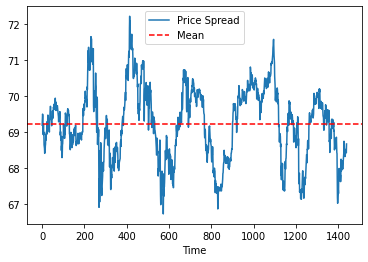

In [42]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [43]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

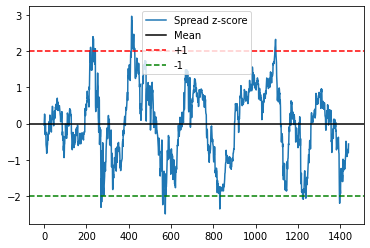

In [44]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])